In [1]:
from huggingface_hub import login
import os

login(token=os.getenv("HF_TOKEN"))

#from huggingface_hub import notebook_login
#notebook_login()

In [1]:
hf_site_id = '2024-mcm-everitt-ryan'
dataset_id = f'{hf_site_id}/possible-bias'

In [2]:
from datasets import load_dataset

dataset = load_dataset(dataset_id)
df = dataset['train'].to_pandas()

Resolving data files:   0%|          | 0/45 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/45 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/44 [00:00<?, ?it/s]

In [3]:
print(f"Column Names: {df.columns}")
print(f"Columns: {len(df.columns)}")
print(f"Rows: {len(df)}")

Column Names: Index(['document_id', 'phrase_index', 'phrase_series', 'source', 'country',
       'company', 'position', 'terms_count_total', 'domain_terms',
       'provisional_terms', 'synthetic_terms', 'terms_count_age',
       'terms_list_age', 'reasons_list_age', 'suggestions_list_age',
       'terms_count_disability', 'terms_list_disability',
       'reasons_list_disability', 'suggestions_list_disability',
       'terms_count_general', 'terms_list_general', 'reasons_list_general',
       'suggestions_list_general', 'terms_count_masculine',
       'terms_list_masculine', 'reasons_list_masculine',
       'suggestions_list_masculine', 'terms_count_feminine',
       'terms_list_feminine', 'reasons_list_feminine',
       'suggestions_list_feminine', 'terms_count_racial', 'terms_list_racial',
       'reasons_list_racial', 'suggestions_list_racial',
       'terms_count_sexuality', 'terms_list_sexuality',
       'reasons_list_sexuality', 'suggestions_list_sexuality',
       'phrase_charac

In [4]:
index0_df = df[df['phrase_index'] == 0]

print(f"Documents: {index0_df.shape[0]}")
print(f"Phrases: {df.shape[0]}")
print(f"Countries: {len(df['country'].unique())}")
print(f"Websites: {len(df['source'].unique())}")
print(f"Companies: {len(df['company'].unique())}")
print(f"Roles: {len(df['position'].unique())}")

Documents: 1693642
Phrases: 2519045
Countries: 81
Websites: 177
Companies: 231559
Roles: 787692


In [5]:
text_col = 'text'
terms_count_cols = [col for col in df.columns if col.startswith('terms_count_')]
terms_list_cols = [col for col in df.columns if col.startswith('terms_list_')]
print(f'terms_count_cols: {len(terms_count_cols)}')
print(f'terms_list_cols: {len(terms_list_cols)}')

terms_count_cols: 8
terms_list_cols: 7


In [6]:
index0_df['phrase_series'].describe(percentiles=[0.90]).loc[['min','max','mean', '90%']]

min      1.000000
max     17.000000
mean     1.550825
90%      2.000000
Name: phrase_series, dtype: float64

In [7]:
word_char_stats = df[[ 'phrase_character_count', 'phrase_word_count']].describe().loc[['min','max','mean', 'std','25%','50%','75%']].T
word_char_stats.sort_values(by='max', ascending=False)

,min,max,mean,std,25%,50%,75%
phrase_character_count,20.0,3000.0,1870.074252,796.946528,1222.0,2104.0,2565.0
phrase_word_count,4.0,400.0,281.238015,117.278435,186.0,319.0,389.0


In [8]:
terms_count_stats = df[terms_count_cols].describe().loc[['min','max','mean', 'std','25%','50%','75%']].T
terms_count_stats.sort_values(by='max', ascending=False)

,min,max,mean,std,25%,50%,75%
terms_count_total,1.0,39.0,7.565196,4.562500,4.0,7.0,11.0
terms_count_masculine,0.0,28.0,4.003326,2.808236,2.0,4.0,6.0
terms_count_disability,0.0,15.0,0.322236,0.762076,0.0,0.0,0.0
terms_count_feminine,0.0,13.0,2.134888,1.771144,1.0,2.0,3.0
terms_count_general,0.0,10.0,0.924530,0.978374,0.0,1.0,1.0
terms_count_age,0.0,5.0,0.121491,0.350114,0.0,0.0,0.0
terms_count_racial,0.0,5.0,0.043106,0.210739,0.0,0.0,0.0
terms_count_sexuality,0.0,4.0,0.015619,0.130660,0.0,0.0,0.0


In [9]:
label_counts = df[terms_count_cols].count().to_dict()
label_counts = {k.replace('terms_count_', ''): v for k, v in label_counts.items()}

df_terms = df[terms_count_cols].copy()
df_terms.rename(columns={col: col.replace('terms_count_', '') for col in df_terms.columns}, inplace=True)
df_terms.head(3)

,total,age,disability,general,masculine,feminine,racial,sexuality
0,10,0,0,1,4,5,0,0
1,6,0,2,1,3,0,0,0
2,10,0,3,2,3,2,0,0


In [10]:
total_terms = df_terms['total'].sum()
label_term_counts = label_counts.copy()
del label_term_counts['total']
total_terms

19057068

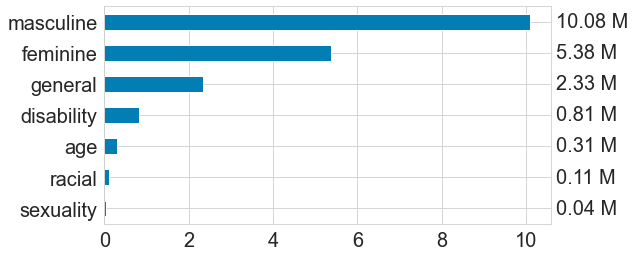

In [20]:
import matplotlib.pyplot as plt

df_category_terms = df_terms.drop(columns=['total'])
df_category_terms[label_term_counts.keys()].sum()

df_terms_sum = df_category_terms[label_term_counts.keys()].sum()
df_terms_sum_sorted = df_terms_sum.sort_values(ascending=True)

plt.figure(figsize=(8, 4))
ax = df_terms_sum_sorted.plot.barh(color='#027EB5')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x / 1e6))))


ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20) 

for i in range(len(df_terms_sum_sorted)):
    ax.text(10700000, i,
            '%.2f M' % (df_terms_sum_sorted.iloc[i] / 1e6),
            fontsize=20,
            va='center')

#total_values = df_terms_sum_sorted.sum(axis=1)


#plt.title('Potential Bias Terms (in Millions)')
plt.show()


In [12]:
import pandas as pd


def value_stats(dataframe, column, format_counts=True):
    counts = dataframe[column].value_counts()
    percentages = (dataframe[column].value_counts(normalize=True) * 100).round(2)

    dataframe = pd.DataFrame({'Count': counts, 'Percentage': percentages.astype(str) + '%'})
    
    if format_counts:
        dataframe['Count'] = dataframe['Count'].apply('{:,}'.format)
    return dataframe


In [13]:
value_stats(index0_df, 'source')

,Count,Percentage
source,,
reed_uk,"186,501",11.01%
britishjobs_uk,"169,192",9.99%
careerbuilder_us,"158,210",9.34%
aarp_us,"139,678",8.25%
seek_au,"127,567",7.53%
...,...,...
efinancialcareers_ie,1,0.0%
eures_be,1,0.0%
simplyhired_ar,1,0.0%


In [14]:
value_stats(index0_df, 'phrase_series')

,Count,Percentage
phrase_series,,
1,"944,943",55.79%
2,"601,323",35.5%
3,"122,139",7.21%
4,"17,869",1.06%
5,"5,059",0.3%
6,"1,210",0.07%
7,604,0.04%
8,283,0.02%
9,156,0.01%


In [15]:
value_stats(index0_df, 'country')

,Count,Percentage
country,,
US,"643,648",38.0%
UK,"594,561",35.11%
AU,"128,427",7.58%
IE,"102,314",6.04%
CA,"34,297",2.03%
...,...,...
BZ,23,0.0%
KG,15,0.0%
AZ,15,0.0%


In [ ]:
value_stats(index0_df, 'company')